# CH4 Redes Neuronales

## Importado de Librerías

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV


import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l1
 
# import visualkeras

np.random.seed(1)
tf.random.set_seed(1) 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

## Lectura CSV y Feature Engineering

In [ ]:
hotels_train_url = "https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/df_hotel_v3.csv"
hotels_test_url = "https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/hotels_test.csv"
df_original = pd.read_csv(hotels_train_url)
df_hotel_test = pd.read_csv(hotels_test_url)
df_hotel_test_con_is_canceled = df_hotel_test.copy()
df_hotel = df_original.copy()

In [ ]:
df_hotel_test = df_hotel_test.drop('id', axis=1)
df_hotel_test = df_hotel_test.drop('arrival_date_week_number', axis=1)
df_hotel_test = df_hotel_test.drop('reservation_status_date', axis=1)
df_hotel_test['children'] = df_hotel_test['children'].astype(int)
df_hotel['is_repeated_guest'] = df_hotel['is_repeated_guest'].astype(int)
df_hotel['is_canceled'] = df_hotel['is_canceled'].astype(int)
df_hotel_test['company'] = df_hotel_test['company'].fillna('not company')
df_hotel_test['company'] = df_hotel_test['company'].astype(str)
df_hotel_test['agent'] = df_hotel_test['agent'].fillna('not agent')
df_hotel_test['agent'] = df_hotel_test['agent'].astype(str)

In [ ]:
# Contamos los valores faltantes
num_missing = df_hotel.isna().sum()
print("El número total de valores faltantes en el DataFrame es:", num_missing.sum())

El número total de valores faltantes en el DataFrame es: 0


In [ ]:
def cambiar_columna_por_probabilidad_is_canceled(columna):
  global df_hotel_test, df_hotel
  probabilidades = df_hotel.groupby(columna)['is_canceled'].mean()
  nueva_columna = columna+'_prob_is_canceled'

  df_hotel[nueva_columna] = 0
  df_hotel[nueva_columna] = df_hotel[columna].map(probabilidades)

  df_hotel_test[nueva_columna] = 0
  df_hotel_test[nueva_columna] = df_hotel_test[columna].map(probabilidades)

  mediana = df_hotel_test[nueva_columna].median()
  df_hotel_test[nueva_columna].fillna(mediana, inplace=True)

  df_hotel_test = df_hotel_test.drop(columna, axis=1)
  df_hotel = df_hotel.drop(columna, axis=1)

In [ ]:
cambiar_columna_por_probabilidad_is_canceled('country')
cambiar_columna_por_probabilidad_is_canceled('agent')
cambiar_columna_por_probabilidad_is_canceled('company')

In [ ]:
X = df_hotel.drop('is_canceled', axis=1)
y = df_hotel['is_canceled']

columns = ['hotel','arrival_date_year', 'arrival_date_month', 'meal', 'market_segment', 'distribution_channel','deposit_type', 'customer_type', 'assigned_room_type', 'reserved_room_type']

X = pd.get_dummies(X, columns=columns, drop_first=True)

df_hotel_test = pd.get_dummies(df_hotel_test, columns=columns, drop_first=True)

In [ ]:
columns_X = set(X.columns)
columns_test = set(df_hotel_test.columns)

missing_columns = list(columns_X - columns_test)
for column in missing_columns:
    df_hotel_test[column] = 0

df_hotel_test = df_hotel_test[X.columns]

## Modelos de prueba

In [ ]:
semilla = 42
np.random.seed(semilla)
tf.random.set_seed(semilla)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

In [ ]:
neurons_output=1

In [ ]:
print(neurons_output)

1


In [ ]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
def create_model(optimizer='adam', activation='relu', neurons_2=32, neurons_3=32):
    modelo = keras.Sequential([
        keras.layers.Dense(68, input_shape=(68,), activation=activation, kernel_initializer='uniform'),
        keras.layers.Dense(neurons_2, activation=activation),
        keras.layers.Dense(neurons_3, activation=activation),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    modelo.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[get_f1]
    )

    modelo.summary()
    
    return modelo

In [ ]:
param_dist = {
    'optimizer': ['adam', 'nadam'],
    'activation': ['relu', 'sigmoid'],
    'neurons_2': [68, 136, 204, 272],
    'neurons_3': [34, 68, 136, 204]
}

modelo_cv = KerasClassifier(build_fn=create_model)

k = 10
kf = KFold(n_splits=k)

random_search = RandomizedSearchCV(
    estimator=modelo_cv,
    param_distributions=param_dist,
    n_iter=10,
    cv=kf,
    random_state=semilla,
    n_jobs=-1
)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

random_search.fit(x_train_scaled, y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 68)                4692      
                                                                 
 dense_37 (Dense)            (None, 204)               14076     
                                                                 
 dense_38 (Dense)            (None, 136)               27880     
                                                                 
 dense_39 (Dense)            (None, 1)                 137       
                                                                 
Total params: 46,785
Trainable params: 46,785
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


1538/1538 [==============================] - 5s 2ms/step - loss: 0.4205 - get_f1: 0.7749


In [ ]:
x_test_scaled = scaler.transform(x_test)

historia_modelo = best_model.fit(x_train_scaled, y_train, epochs=100, batch_size=16)

y_pred_train = best_model.predict(x_train_scaled)
f1_train = f1_score(y_train, y_pred_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
scores_train = {'f1': f1_train, 'accuracy': accuracy_train, 'precision':precision_train}

y_pred_test = best_model.predict(x_test_scaled)
f1_test = f1_score(y_test, y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
scores_test = {'f1': f1_test, 'accuracy': accuracy_test, 'precision':precision_test}

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 68)                4692      
                                                                 
 dense_49 (Dense)            (None, 204)               14076     
                                                                 
 dense_50 (Dense)            (None, 136)               27880     
                                                                 
 dense_51 (Dense)            (None, 1)                 137       
                                                                 
Total params: 46,785
Trainable params: 46,785
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3075/3075 [==============================] - 9s 3ms/step - loss: 0.4101 - get_f1: 0.7788
Epoch 2/100
3075/3075 [==============================] - 7s 2ms/step - loss: 0.3

In [ ]:
print("Mejores hiperparámetros encontrados:", best_params)
print("Metricas en el conjunto de train:", scores_train)
print("Metricas en el conjunto de test:", scores_test)

Mejores hiperparámetros encontrados: {'optimizer': 'adam', 'neurons_3': 136, 'neurons_2': 204, 'activation': 'sigmoid'}
Metricas en el conjunto de train: {'f1': 0.9475054577500049, 'accuracy': 0.9467189786957229, 'precision': 0.9376833425830492}
Metricas en el conjunto de test: {'f1': 0.8524669073405536, 'accuracy': 0.8504634899983737, 'precision': 0.8370883882149047}


Como podemos ver, el puntaje F1 en train es muy superior al de test. Esto es un claro signo de overfitting, lo cual es esperado ya que usamos una red neuronal sin regularización y muchos ciclos. En las otras redes neuronal vemos como esto se soluciona utilizando métodos de regularización como Early Stopping o L2

## Exportado de Predicciones


In [ ]:
import joblib
joblib.dump(best_model, 'modelo_red_neuronal_sin_regularizacion.pkl')
loaded_model = joblib.load('modelo_red_neuronal_sin_regularizacion.pkl')
predicciones = loaded_model.predict(df_hotel_test)

830/830 [==============================] - 1s 1ms/step


In [ ]:
df_sub = pd.DataFrame({'id': df_hotel_test_con_is_canceled['id'], 'is_canceled': np.ravel(predicciones)})
df_sub.to_csv('prediccion_modelo_red_neuronal_sin_regularizacion.csv', index=False)

## Métricas

### Matriz de Confusión

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      6180
           1       0.84      0.87      0.85      6118

    accuracy                           0.85     12298
   macro avg       0.85      0.85      0.85     12298
weighted avg       0.85      0.85      0.85     12298



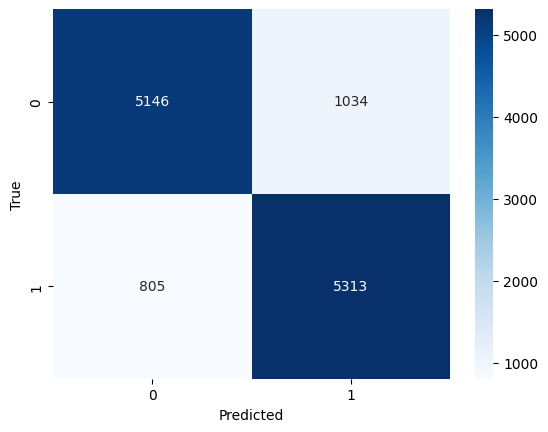

In [ ]:
cm = confusion_matrix(y_test,y_pred_test)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print(classification_report(y_test,y_pred_test))

### Gráficos de las métricas en función de los ciclos (epochs)

In [ ]:
print(historia_modelo.history)

{'loss': [0.4101329445838928, 0.37465229630470276, 0.35957029461860657, 0.3516882061958313, 0.34374234080314636, 0.33755192160606384, 0.3310898542404175, 0.3249877095222473, 0.3196892738342285, 0.3146761953830719, 0.3100767731666565, 0.3058880865573883, 0.3020849823951721, 0.29800623655319214, 0.2953578531742096, 0.29210153222084045, 0.288348525762558, 0.28537699580192566, 0.28302454948425293, 0.2792367935180664, 0.2767992615699768, 0.27434036135673523, 0.2721564769744873, 0.26872196793556213, 0.2663952112197876, 0.26350054144859314, 0.2618139684200287, 0.2591308653354645, 0.2567841708660126, 0.25468817353248596, 0.2517850697040558, 0.2501855492591858, 0.24821965396404266, 0.24618174135684967, 0.24348652362823486, 0.24254994094371796, 0.2403450757265091, 0.2381742298603058, 0.23500260710716248, 0.23349535465240479, 0.23246105015277863, 0.22983361780643463, 0.22762835025787354, 0.22638747096061707, 0.22329631447792053, 0.22169139981269836, 0.21999096870422363, 0.21765485405921936, 0.215

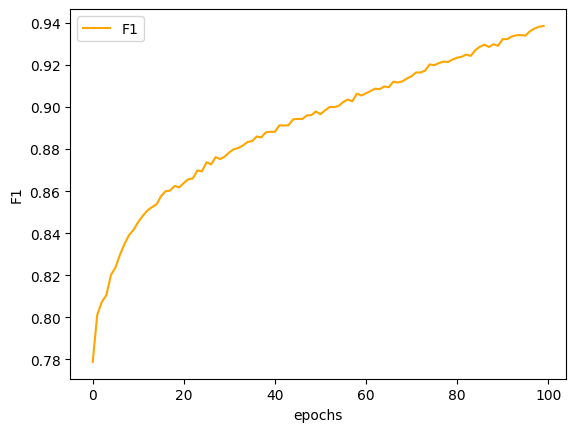

In [ ]:
epochs = range(100)

plt.plot(epochs, historia_modelo.history['get_f1'], color='orange', label='F1')
plt.xlabel("epochs")
plt.ylabel("F1")
plt.legend()

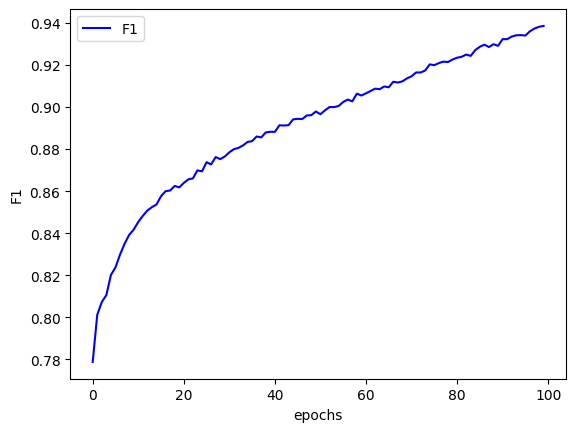

In [ ]:
epochs = range(100)

plt.plot(epochs, historia_modelo.history['get_f1'], color='blue', label='F1')
plt.xlabel("epochs")
plt.ylabel("F1")
plt.legend()

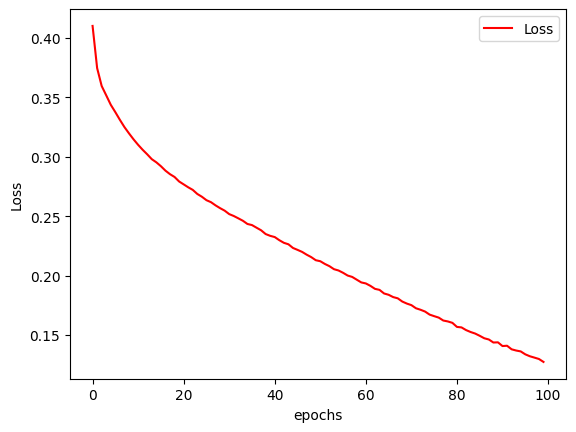

In [ ]:
epochs = range(100)

plt.plot(epochs, historia_modelo.history['loss'], color='red', label='Loss')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()

Podemos observar que si se corta el entrenamiento cerca de los 40 ciclos podemos evitar el sobreajuste. Además de eso se puede observar que pasados los 20 ciclos el crecimiento de las métricas de precision, f1 y area bajo la curva (y el decrecimiento de la pérdida) se vuelve lineal, y suponemos que esto se debe a que la red no utiliza un metodo de regularización, ya que si lo comparamos con el modelo que utiliza L2 vemos un crecimiento asintótico. 